In [2]:
import numpy as np
import pandas as pd
import datetime
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import yfinance as yf
%matplotlib inline
pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')

In [3]:
pd.set_option('display.max_rows', None)

In [292]:
pd.reset_option('display.max_rows')

In [293]:
pd.set_option('display.max_rows', 10)

In [4]:

def get_prices_online(symbols:[], start_date, end_date):
    # Combine all the data files into a single dataframe
    combined_df = pd.DataFrame()
    # Fetch the data and save to CSV files
    for symbol in symbols:
        df = yf.download(symbol, start=start_date, end=end_date)
        df['Close'].to_csv(f'{symbol}_closing_prices.csv')
        combined_df[symbol] = df['Close']

    return combined_df

def get_prices_files(symbols:[]):#-> pd.DataFrame:
    combined_df = pd.DataFrame()
    for symbol in symbols:
        df = pd.read_csv(f'{symbol}_closing_prices.csv', index_col=0, parse_dates=True)
        combined_df[symbol] = df[symbol]

    return combined_df

def append_months_weeks_days(df) :#-> pd.DataFrame:
    # Extract month and week of the year and day of the week
    df = df.copy() # Don't affect the original dataframe
    df['Year'] = df.index.year
    df['Quarter'] = df.index.quarter
    df['Month'] = df.index.month
    df['Week'] = df.index.isocalendar().week
    df['Day'] = df.index.dayofweek
    
    df['Prez'] = ((df['Year'] - 1) % 4) + 1 # Presidential election year
    return df

def log_daily_return(df):
    df_ret = np.log(df/df.shift(1))
    return df_ret

def get_prices_pct_change(symbols:[], start_date, end_date, use_files: bool=True):
    if use_files:
        df = get_prices_files(symbols)
    else:
        df = get_prices_online(symbols, start_date, end_date)

    df = df.dropna(axis=0)
    df_log = log_daily_return(df)
    df = append_months_weeks_days(df)
    df_log = append_months_weeks_days(df_log).dropna(axis=0)
    return df, df_log

def mean_daily_return_by_week(df):
    df['Daily Return'] = df['Adj. Close'].pct_change()
    weekly_mean_return = df.groupby('Week')['Daily Return'].mean().reset_index()
    return weekly_mean_return


def prices_by_period(df:pd.DataFrame, period:str, num_list:[], ret_columns):
    # num == 0 for return all values
    # Num > 0 for specific value
    if num_list != []:
        df_ret = df[df[period].isin(num_list)][ret_columns]
    else:
        df_ret = df[ret_columns]
    return df_ret

def log_mean_daily_return_by_week(df):
    df['Daily Return'] = np.log(df['Adj. Close']/df['Adj. Close'].shift(1))
    log_weekly_mean_return = df.groupby('Week')['Daily Return'].sum().reset_index()
    return log_weekly_mean_return

# Extract for specific period
def extract_for_period(period:str, period_num_list:[], ret_columns:[], df:pd.DataFrame):
    df = df.copy()
    #df = append_months_weeks_days(df)
    # period_num_list == [] for return all values
    # period_num_list != [] for specific value(s)
    if period_num_list != []:
        df_ret = df[df[period].isin(period_num_list)]
        #df_ret = df_ret.groupby(['Year', period])[ret_columns].sum() # Group by period
    else:
        # Want all periods so leave as days
        df_ret = df
        
    # 252 days in year  12 Months in a year 4 Quarters in a year  52 weeks in a year  5 days in a week 
    if period_num_list == []:
        periods_per_year = 252
    elif period == 'Month':
        periods_per_year = 12
    elif period == 'Quarter':
        periods_per_year = 4
    elif period == 'Week':
        periods_per_year = 52
    elif period == 'Day':
        periods_per_year = 252
    else:
        periods_per_year = 1
        
    return df_ret, periods_per_year


def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array of return,volatility, sharpe ratio
    """
    global g_log_ret
    global g_num_periods
    weights = np.array(weights)
    ret = np.sum(g_log_ret.mean() * weights) * g_num_periods
    vol = np.sqrt(np.dot(weights.T, np.dot(g_log_ret.cov() * g_num_periods, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

def neg_return(weights):
    return  get_ret_vol_sr(weights)[0] * -1

# Constraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 

def get_max_return():
    num_stocks = len(g_log_ret.columns)
    # By convention of minimize function it should be a function that returns zero for conditions
    cons = ({'type':'eq','fun': check_sum})
    # 0-1 bounds for each weight
    bounds = tuple((0, 1) for _ in range(num_stocks))

    # Initial Guess (equal distribution)
    init_guess = [1/num_stocks for _ in range(num_stocks)]
    # Get max possible return to give limits for the efficient frontier calculation
    opt_results = minimize(fun=neg_return,x0=init_guess,method='SLSQP',bounds=bounds,constraints=cons)

    max_return = get_ret_vol_sr(opt_results.x)[0]
    return max_return

def get_max_sharp_portfolio():
    # By convention of minimize function it should be a function that returns zero for conditions
    cons = ({'type':'eq','fun': check_sum})
    # 0-1 bounds for each weight
    num_stocks = len(g_log_ret.columns)
    bounds = tuple((0, 1) for _ in range(num_stocks))

    # Initial Guess (equal distribution)
    init_guess = [1/num_stocks for _ in range(num_stocks)]
    # Get max Sharp Ratio
    opt_results = minimize(fun=neg_sharpe,x0=init_guess,method='SLSQP',bounds=bounds,constraints=cons)

    df_portfolio = (opt_results.x)
    # return the portfolio corresponding to the maximum sharp ratio along with the sharp ratio
    return df_portfolio, -opt_results.fun

def get_min_volatility_portfolio():
    # By convention of minimize function it should be a function that returns zero for conditions
    cons = ({'type':'eq','fun': check_sum})
    # 0-1 bounds for each weight
    bounds = tuple((0, 1) for _ in range(num_stocks))

    # Initial Guess (equal distribution)
    init_guess = [1/num_stocks for _ in range(num_stocks)]
    # Get min volatility
    opt_results = minimize(fun=minimize_volatility,x0=init_guess,method='SLSQP',bounds=bounds,constraints=cons)

    df_portfolio = (opt_results.x)
    return df_portfolio

def decode_ret_vol_sr(df_portfolio):
    list_set = get_ret_vol_sr(df_portfolio)
    ret_val = list_set[0]
    vol_val = list_set[1]
    sr_val = list_set[2]
    return ret_val, vol_val, sr_val

def get_efficient_frontier():
    num_stocks = len(g_log_ret.columns)
    # Our returns go from 0 to max_return
    max_return = get_max_return()
    # Initial Guess (equal distribution)
    init_guess = [1/num_stocks for _ in range(num_stocks)]
    # 0-1 bounds for each weight
    bounds = tuple((0, 1) for _ in range(num_stocks))
    
    # Create a linspace number of points to calculate x on
    frontier_y = np.linspace(0,max_return,100) # Change 100 to a lower number for slower computers!
    frontier_volatility = []
    portfolios = []

    for possible_return in frontier_y:
        # function for return
        cons = ({'type':'eq','fun': check_sum},
                {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
        
        result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
        ret_val, vol_val, sr_val = decode_ret_vol_sr(result['x'])
        portfolios.append([result['x'], possible_return, result['fun'], sr_val])
    df_ret = pd.DataFrame(portfolios, columns=['Weights', 'Return', 'Volatility', 'Sharp Ratio'])
    # Add in drawdown
    df_ret = calculate_drawdown(df_ret)
    return df_ret

def plot_efficient_frontier(df):
    # get volatility and returns
    vol_arr = df['Volatility'].to_numpy()
    ret_arr = df['Return'].to_numpy()
    sharp_arr = df['Sharp Ratio'].to_numpy()
    # max_return = get_max_return()
    # min_volatility = get_min_volatility_portfolio()
    df_portfolio, max_sharp = get_max_sharp_portfolio()
    ret_val, vol_val, sr_val = decode_ret_vol_sr(df_portfolio.round(4))
    plt.figure(figsize=(12,8))


    plt.scatter(vol_arr,ret_arr,c=sharp_arr,cmap='plasma')
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.scatter(vol_val,ret_val,c='red',s=50,edgecolors='black')
    print(symbols)
    print('Max. Sharp Ratio: ',sr_val, ' Ret:', ret_val, ' Vol: ', vol_val, ' weights: ',df_portfolio.round(4))

    # Add frontier line
    #plt.plot(vol_arr,ret_arr,'g--',linewidth=3)
    plt.show()

In [5]:
# Function to calculate rolling window portfolio metrics
def rolling_window_portfolio(stock_data):
    window_size = 3 * 252  # 3 years of trading days
    step_size = 252  # 1 year of trading days
    
    results = []
    
    for start in range(0, len(stock_data) - window_size + 1, step_size):
        end = start + window_size
        window_data = stock_data.iloc[start:end]
        
        mean_returns = window_data.pct_change().mean()
        cov_matrix = window_data.pct_change().cov()
        
        optimized_result = optimize_portfolio(mean_returns, cov_matrix)
        
        weights = optimized_result.x
        returns, std_dev = portfolio_performance(weights, mean_returns, cov_matrix)
        
        drawdown = (window_data / window_data.cummax() - 1).min().min()
        max_profit = (window_data.iloc[-1] / window_data.iloc[0] - 1).max()
        sharpe_ratio = -optimized_result.fun
        
        results.append({
            'Start Date': window_data.index[0],
            'End Date': window_data.index[-1],
            'Return': returns,
            'Volatility': std_dev,
            'Drawdown': drawdown,
            'Max Profit': max_profit,
            'Sharpe Ratio': sharpe_ratio
        })
    

# Start Run - Get Price Data

In [18]:
# Define the list of stock symbols
symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
symbols = ['GLD', 'SPY', 'QQQ', 'BND']
symbols =  ['AAPL', 'MSFT', 'GOOGL']
start_date = '2000-01-01'
end_date = '2024-12-31'

df_prices, df_log_change = get_prices_pct_change(symbols=symbols, start_date=start_date, end_date=end_date, use_files=False)

num_stocks = len(df_prices.columns)

print(df_prices)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                  AAPL        MSFT       GOOGL  Year  Quarter  Month  Week  \
Date                                                                         
2004-08-19    0.462595   16.836214    2.501941  2004        3      8    34   
2004-08-20    0.463951   16.885872    2.700670  2004        3      8    34   
2004-08-23    0.468169   16.960590    2.727849  2004        3      8    35   
2004-08-24    0.481274   16.960590    2.614895  2004        3      8    35   
2004-08-25    0.497844   17.153606    2.643072  2004        3      8    35   
...                ...         ...         ...   ...      ...    ...   ...   
2024-12-23  255.270004  435.250000  194.630005  2024        4     12    52   
2024-12-24  258.200012  439.329987  196.110001  2024        4     12    52   
2024-12-26  259.019989  438.109985  195.600006  2024        4     12    52   
2024-12-27  255.589996  430.529999  192.759995  2024        4     12    52   
2024-12-30  252.199997  424.829987  191.240005  2024        4   

In [4]:
def calculate_compounded_return(log_returns):
    #log_returns = df_log_change[symbols].sum()

    compounded_return = np.exp(log_returns.sum()) - 1
    return compounded_return

# Example usage
calculate_compounded_return(df_log_change[symbols].sum())

np.float64(449.9433325063895)

In [24]:
compounded_returns = {}
for symbol in symbols:
    log_returns = df_log_change[symbol].dropna()
    compounded_returns[symbol] = calculate_compounded_return(log_returns) * 100

print(compounded_returns)

{'AAPL': np.float64(54418.476126469366), 'MSFT': np.float64(2423.3106737547405), 'GOOGL': np.float64(7543.665782629323)}


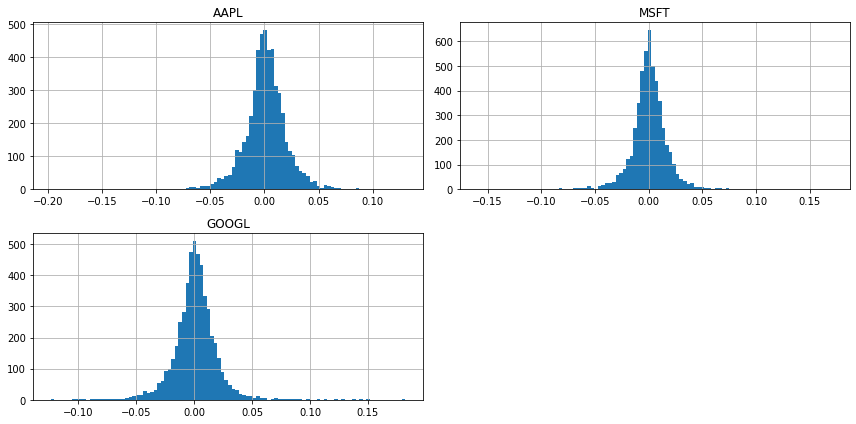

In [25]:
df_log_change[symbols].hist(bins=100,figsize=(12,6));
plt.tight_layout()

# Select a new period

In [26]:
period_type = 'Day'
period_num_list = []
log_ret, num_periods_in_year = extract_for_period(period_type, period_num_list, symbols, df_log_change)

In [32]:
df_span_prices = pd.DataFrame()

for symbol in symbols:
    initial_price = 100.0
    date_str = log_ret.index[0]

    prices = [initial_price]
    for ind in range(len(log_ret)):
        initial_price = initial_price + initial_price * log_ret[symbol].iloc[ind]
        prices.append(initial_price)
    df_span_prices[symbol]=prices





In [34]:
log_ret[symbol]

Date
2004-08-19         NaN
2004-08-20    0.076433
2004-08-23    0.010014
2004-08-24   -0.042290
2004-08-25    0.010718
                ...   
2024-12-23    0.016683
2024-12-24    0.007575
2024-12-26   -0.002604
2024-12-27   -0.014626
2024-12-30   -0.007917
Name: GOOGL, Length: 5126, dtype: float64

In [ ]:
# Create a new index starting with new_date_str and followed by the dates from log_ret
# Subtract one day from start date
new_date_str = (pd.to_datetime(date_str) - pd.Timedelta(days=1))#.strftime('%Y-%m-%d')
new_index = [new_date_str] + log_ret.index.tolist()

# Reindex df_span_prices with the new index
df_span_prices.index = new_index
df_span_prices.index = df_span_prices.index.normalize()
    

In [31]:
log_ret.index.tolist()

[Timestamp('2004-08-19 00:00:00'),
 Timestamp('2004-08-20 00:00:00'),
 Timestamp('2004-08-23 00:00:00'),
 Timestamp('2004-08-24 00:00:00'),
 Timestamp('2004-08-25 00:00:00'),
 Timestamp('2004-08-26 00:00:00'),
 Timestamp('2004-08-27 00:00:00'),
 Timestamp('2004-08-30 00:00:00'),
 Timestamp('2004-08-31 00:00:00'),
 Timestamp('2004-09-01 00:00:00'),
 Timestamp('2004-09-02 00:00:00'),
 Timestamp('2004-09-03 00:00:00'),
 Timestamp('2004-09-07 00:00:00'),
 Timestamp('2004-09-08 00:00:00'),
 Timestamp('2004-09-09 00:00:00'),
 Timestamp('2004-09-10 00:00:00'),
 Timestamp('2004-09-13 00:00:00'),
 Timestamp('2004-09-14 00:00:00'),
 Timestamp('2004-09-15 00:00:00'),
 Timestamp('2004-09-16 00:00:00'),
 Timestamp('2004-09-17 00:00:00'),
 Timestamp('2004-09-20 00:00:00'),
 Timestamp('2004-09-21 00:00:00'),
 Timestamp('2004-09-22 00:00:00'),
 Timestamp('2004-09-23 00:00:00'),
 Timestamp('2004-09-24 00:00:00'),
 Timestamp('2004-09-27 00:00:00'),
 Timestamp('2004-09-28 00:00:00'),
 Timestamp('2004-09-

<Axes: >

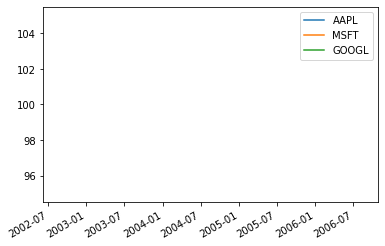

In [28]:
df_span_prices.plot()

In [80]:
# Set Globals for Efficient Frontier calculations
g_log_ret = log_ret[symbols]
g_num_periods =  num_periods_in_year
print(g_log_ret, g_num_periods)

                 GLD       SPY       QQQ       BND
Date                                              
2007-12-03  0.012339 -0.006614 -0.008416  0.004886
2007-12-04  0.014206 -0.008979 -0.004136 -0.000517
2007-12-05 -0.009745  0.016601  0.017800 -0.002201
2007-12-06  0.009367  0.014212  0.014245 -0.005197
2007-12-07 -0.009749 -0.000199  0.000191 -0.003263
...              ...       ...       ...       ...
2024-12-23 -0.004720  0.005970  0.009696 -0.003190
2024-12-24  0.001990  0.011054  0.013469  0.001435
2024-12-26  0.006728  0.000067 -0.000680  0.000696
2024-12-27 -0.006894 -0.010582 -0.013382 -0.002088
2024-12-30 -0.003195 -0.011477 -0.013389  0.003895

[378 rows x 4 columns] 12


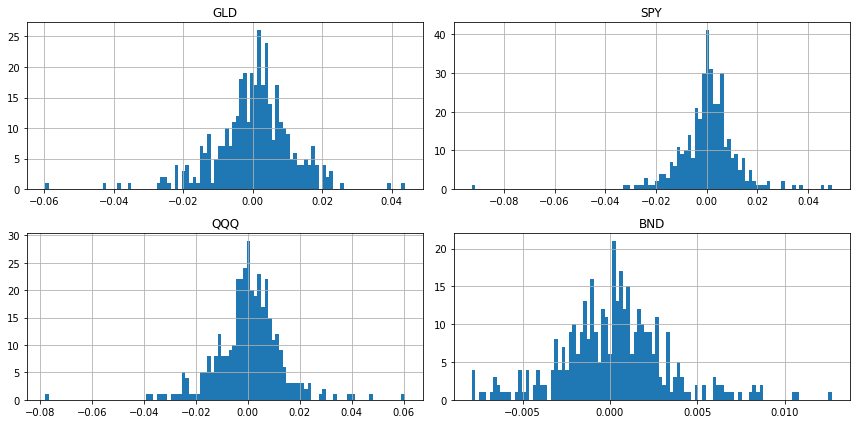

In [81]:

g_log_ret.hist(bins=100,figsize=(12,6))

plt.tight_layout()



In [82]:
df_portfolio, max_sharp_ratio = get_max_sharp_portfolio()
ret_val, vol_val, sr_val = decode_ret_vol_sr(df_portfolio)
print (symbols, df_portfolio, ret_val, vol_val, sr_val)

['GLD', 'SPY', 'QQQ', 'BND'] [0.03041108 0.13889613 0.         0.83069279] 0.0023874802701369818 0.009995945220095392 0.2388448733529772


In [83]:
df_portfolio.round(4)

array([0.0304, 0.1389, 0.    , 0.8307])

# All Optimal Portfolios (Efficient Frontier)

The efficient frontier is the set of optimal portfolios that offers the highest expected return for a defined level of risk or the lowest risk for a given level of expected return. Portfolios that lie below the efficient frontier are sub-optimal, because they do not provide enough return for the level of risk. Portfolios that cluster to the right of the efficient frontier are also sub-optimal, because they have a higher level of risk for the defined rate of return.

Efficient Frontier http://www.investopedia.com/terms/e/efficientfrontier

In [93]:
df_portfolios = get_efficient_frontier()
df_portfolios.round(4)

,Weights,Return,Volatility,Sharp Ratio
0,"[4.1783194873391244e-13, 4.962726350839542e-14...",0.0000,0.0107,0.1939
1,"[4.473779161630431e-17, 6.711455891553487e-17,...",0.0000,0.0107,0.1939
2,"[3.9967754555682324e-13, 2.907289323175642e-13...",0.0001,0.0107,0.1939
3,"[3.401322882514126e-17, 2.5284525409025276e-17...",0.0001,0.0107,0.1939
4,"[8.279242441423304e-17, 2.7670672506518762e-17...",0.0002,0.0107,0.1939
...,...,...,...,...
95,"[0.4418200218063482, 0.3763317486139498, 0.0, ...",0.0036,0.0258,0.1405
96,"[0.4545446578686062, 0.3836131726906661, 0.0, ...",0.0037,0.0264,0.1387
97,"[0.46726264669345763, 0.39090195707097075, 0.0...",0.0037,0.0270,0.1370
98,"[0.47997515351282705, 0.39819681352095015, 3.9...",0.0037,0.0276,0.1353


['GLD', 'SPY', 'QQQ', 'BND']
Max. Sharp Ratio:  0.23884487399888218  Ret: 0.0023874652785113282  Vol:  0.009995882425856466  weights:  [0.0304 0.1389 0.     0.8307]


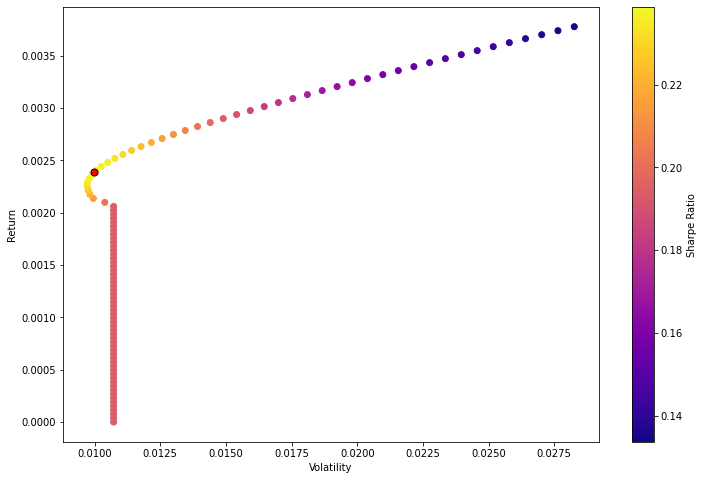

In [101]:
plot_efficient_frontier(df_portfolios)

['GLD', 'SPY', 'QQQ', 'BND']
Max. Sharp Ratio:  0.23884487399888218  Ret: 0.0023874652785113282  Vol:  0.009995882425856466  weights:  [0.0304 0.1389 0.     0.8307]


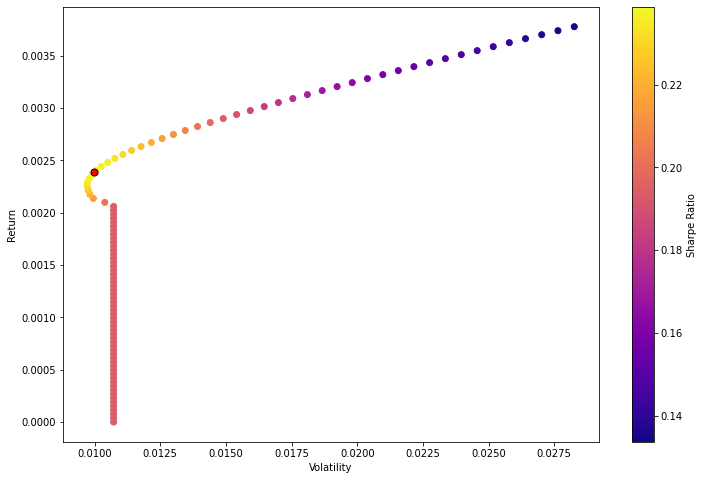

In [99]:
df = df_portfolios
 # get volatility and returns
vol_arr = df['Volatility'].to_numpy()
ret_arr = df['Return'].to_numpy()
sharp_arr = df['Sharp Ratio'].to_numpy()
# max_return = get_max_return()
# min_volatility = get_min_volatility_portfolio()
df_portfolio, max_sharp = get_max_sharp_portfolio()
ret_val, vol_val, sr_val = decode_ret_vol_sr(df_portfolio.round(4))
plt.figure(figsize=(12,8))


plt.scatter(vol_arr,ret_arr,c=sharp_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(vol_val,ret_val,c='red',s=50,edgecolors='black')
print(symbols)
print('Max. Sharp Ratio: ',sr_val, ' Ret:', ret_val, ' Vol: ', vol_val, ' weights: ',df_portfolio.round(4))

# Add frontier line
#plt.plot(vol_arr,ret_arr,'g--',linewidth=3)
plt.show()

Text(0, 0.5, 'Return')

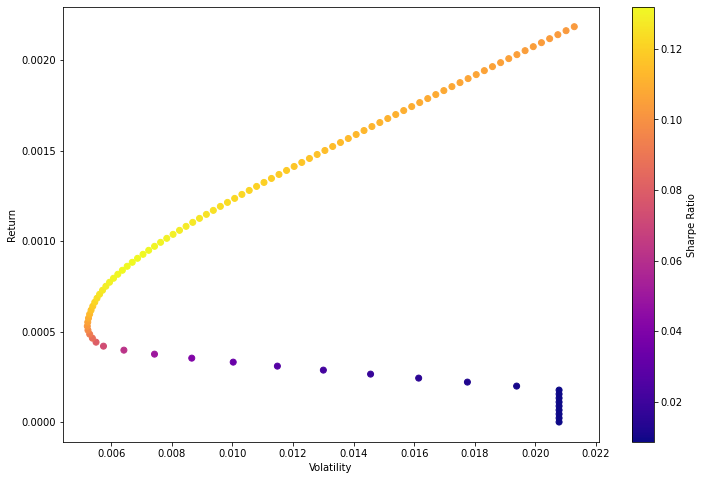

In [305]:

vol_arr = df_portfolios['Volatility'].to_numpy()
ret_arr = df_portfolios['Return'].to_numpy()
sharpe_arr = df_portfolios['Sharp Ratio'].to_numpy()
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add red dot for max SR
#plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')
#print(max_sr_vol,max_sr_ret, 'Ret:', ret_arr[max_sharp_arg], ' weights: ',all_weights[max_sharp_arg])

# Add frontier line
#plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)

In [302]:
(vol_arr)

array([0.04693156, 0.04693156, 0.04693156, 0.04693156, 0.04693156,
       0.04693156, 0.04693156, 0.04693156, 0.04693156, 0.04693156,
       0.04693156, 0.04693156, 0.04693156, 0.04693156, 0.04693156,
       0.04693156, 0.04693156, 0.04693156, 0.04693156, 0.04693156,
       0.04693156, 0.04693156, 0.04693156, 0.04693156, 0.04693156,
       0.04693156, 0.04693156, 0.04693156, 0.04693156, 0.04693156,
       0.04693156, 0.04693156, 0.04693156, 0.04693156, 0.04693156,
       0.04693156, 0.04693156, 0.04693156, 0.04693156, 0.04693156,
       0.04693156, 0.04693156, 0.04693156, 0.04693156, 0.04693156,
       0.04693156, 0.04693156, 0.04693156, 0.04693156, 0.04693156,
       0.04693156, 0.04693156, 0.04693156, 0.04693156, 0.04693156,
       0.04693156, 0.04693156, 0.04693156, 0.04693156, 0.04693156,
       0.04693156, 0.04693156, 0.04693156, 0.04693156, 0.04693156,
       0.04693156, 0.04693156, 0.04693156, 0.04693156, 0.04693156,
       0.04693156, 0.04693156, 0.04693156, 0.04693156, 0.04693